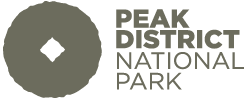

# Creating target 'engagement areas' for school establishments in the Peak District Region

## Introduction
This preliminary analysis, will support evidence for the the Engagement Team and their delivery towards the PDNPA Diverse Audience Plan. This analysis sets out aims to identify shcools that will enable us to work with a more diverse range of groups: 
* targeting local schools who are located in socio-econimically deprived areas, 
* schools with a high level of free school meals (FSM),
* or have higher levels of English as a foreign language (EFL). 

The PDNPA Engagement Service are  developing “new products” beyond our current norm (welcoming school groups to sessions which we lead for them, from a handful of fixed locations in the PDNP) therefore we will focus our delivery and target area on these locations:
* Longdendale Environmental Centre (SK13 1HS)
* Longshaw’s Moorland Discovery Centre (S11 7TZ)
* Macclesfield Forest (SK11 0NS)


This is a reproducible data dictionary based on a python script to scrape open data in order to perform analysis for PDNPA. As this is a script, it can be re-run as and when the data is updated. This analysis is reproducible meaning this analysis can be copied or investigated and improved on. For further details contact;

david.alexander@peakdistrict.gov.uk

*...only .zip functions are undertaken manually in the arcgis desktop environment for speed and ease of data manipulation. This can be added to code if needed...*

*...screenshots are showed where map widgets would be due to hosting this .ipynb on GitHub...*

## Methodology

1. Create a point file for the fixed locations (engagement centres) above 
2. Create 1 hour drive times for the engagement centres
2. Merge the polygons to create the 'Engagement Schools Target Area'
3. Webscrape the schools establishment data from [gov.uk](https://get-information-schools.service.gov.uk/Downloads)
4. Query the school establishments spatially
5. Plot the information ready for further analysis with the Engagement Team

## Data Engineering

In [1]:
# Manage the GIS
from arcgis import GIS
import arcpy
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
mygis = GIS("Pro")
print(mygis)

GIS @ https://www.arcgis.com/ version:8.3


In [2]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = "C:/Users/alexad/Documents/ArcGIS/Projects/Engagement_Schools_Area/Engagement_Schools_Area.gdb"

##### (1) Create a point .shp file for the Engagement Centres

In [5]:
# create a point array (Longdendale (1) Longshaw (2) Macclesfield Forest (3))
coordinates = [(1, 402819, 397128),
               (2, 426432, 379889),
               (3, 396041, 371259)]

spatial_ref = arcpy.SpatialReference(27700)
pt = arcpy.Point()
ptGeoms = []
for p in coordinates:
    pt.ID = p[0]
    pt.X = p[1]
    pt.Y = p[2]
    ptGeoms.append(arcpy.PointGeometry(pt, spatial_ref))

arcpy.CopyFeatures_management(ptGeoms, r"Engagement_points.shp")

<Result 'C:/Users/alexad/Documents/ArcGIS/Projects/Engagement_Schools_Area\\Engagement_points.shp'>

Lets create a quick map widget to check the data created is OK ;)

1. Publish the shp ***pdnpa/arcgis.com/content***
2. Display on a map widget

In [6]:
Engagement_points_properties = {"title": "Engagement Points",
                               "description": "points of education centres",
                               "tags": "points, engagement",
                               "type": "Shapefile"}

In [10]:
Engagement_points_item = mygis.content.add(Engagement_points_properties, data = r"Engagement_points.zip")
Engagement_points_item = Engagement_points_item.publish()

<Item title:"Engagement Points" type:Feature Layer Collection owner:david.alexander_PDNPA>
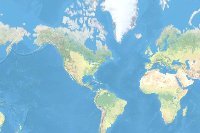

In [3]:
Engagement_points_item = mygis.content.get("3ef215296175477ea183f5f43c4102a5")
display(Engagement_points_item)

In [121]:
# take a look :)
Engagement_schools_map = mygis.map()
Engagement_schools_map.add_layer(Engagement_points_item)
Engagement_schools_map.center = [53.3, -1.70]
Engagement_schools_map.zoom = 9
Engagement_schools_map

MapView(layout=Layout(height='400px', width='100%'))

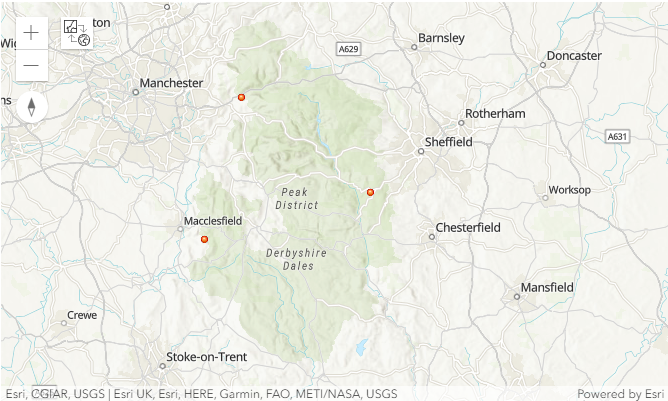

##### (2) Create hour travel time polygons using the [Generate Service Areas tool](https://pro.arcgis.com/en/pro-app/tool-reference/ready-to-use/itemdesc-generate-service-areas.htm)

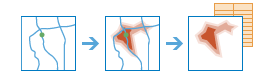

In [35]:
# set the env up for the tool
import sys
import time
sa_service = "https://logistics.arcgis.com/arcgis/services;World/ServiceAreas;{0};{1}".format('user', 'Password')
arcpy.ImportToolbox(sa_service)

<module 'ServiceAreas'>

In [70]:
# set tool variables
Edu_Bases = r"Engagement_points.shp"
Engagement_areas = r"Engagement_Schools_Area.gdb/Engagement_areas_30"

In [71]:
# call the tool
result = arcpy.GenerateServiceAreas_ServiceAreas(Edu_Bases, "30", "Minutes")
arcpy.AddMessage("Running the analysis with result ID: {}".format(result.resultID))

# check the status of the result object every 1 second until it has a
# value of 4 (succeeded) or greater
while result.status < 4:
    time.sleep(1)

# print any warning or error messages returned from the tool
result_severity = result.maxSeverity
if result_severity == 2:
    arcpy.AddError("An error occured when running the tool")
    arcpy.AddError(result.getMessages(2))
    sys.exit(2)
elif result_severity == 1:
    arcpy.AddWarning("Warnings were returned when running the tool")
    arcpy.AddWarning(result.getMessages(1))

# store the output drive time polygons to a geodatabase
result.getOutput(0).save(Engagement_areas)

#### (3) Merge & disolve the polygons to create the 'Engagement Schools Target Area'

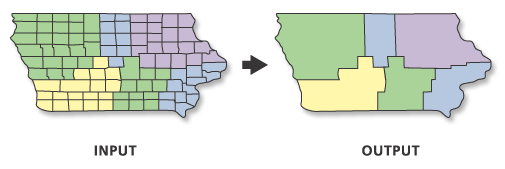

In [93]:
# disolve the 30 min drive time polygons to one area
Target_area = arcpy.Dissolve_management("Engagement_areas_30", "Target_area", ["FromBreak"], "")

Lets create a quick map widget to check the data created is OK ;)

1. Publish the shp ***pdnpa/arcgis.com/content***
2. Display on a map widget

In [20]:
# define the properties
Target_area_properties = {"title": "Target Engagement Area",
                          "description": "areas of 30 mins drive time from education centres",
                          "tags": "polygon, engagement",
                          "type": "Shapefile"}

In [22]:
# add & publish to pdnpa/arcgis
Target_area_item = mygis.content.add(Target_area_properties, data = r"Target_area.zip")
Target_area_item = Target_area_item.publish()

<Item title:"Target Engagement Area" type:Feature Layer Collection owner:david.alexander_PDNPA>
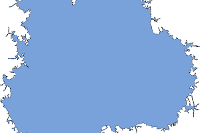

In [6]:
# show the published data
Target_area_item = mygis.content.get("7add4ebf23464859bfadebe7c66ef5a2")
display(Target_area_item)

In [120]:
# take a look :)
Engagement_schools_map.add_layer(Target_area_item)
Engagement_schools_map

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

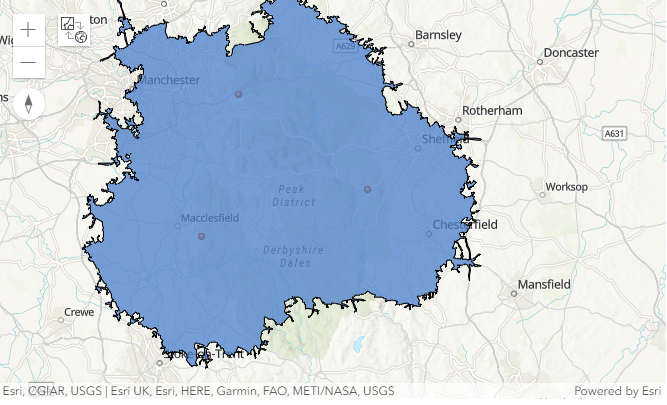

##### (4) Webscrape the schools establishment data from gov.uk

In [112]:
# download the Gov.UK data
import io
import requests
url = "https://ea-edubase-api-prod.azurewebsites.net/edubase/downloads/public/edubasealldata20201108.csv"
s = requests.get(url).content
edu_df = pd.read_csv(s)

In [42]:
# import to gis a pandas df
#edu_df = gpd.read_file(r"edubasealldata20201108.csv", encoding="latin-1")
edu_df = gpd.read_file(r"edubasealldata20201108.csv")
# take a look a the first 5 rows
edu_df.head(5)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),EstablishmentStatus (name),ReasonEstablishmentOpened (code),ReasonEstablishmentOpened (name),OpenDate,ReasonEstablishmentClosed (code),ReasonEstablishmentClosed (name),CloseDate,PhaseOfEducation (code),PhaseOfEducation (name),StatutoryLowAge,StatutoryHighAge,Boarders (code),Boarders (name),NurseryProvision (name),OfficialSixthForm (code),OfficialSixthForm (name),Gender (code),Gender (name),ReligiousCharacter (code),ReligiousCharacter (name),ReligiousEthos (name),Diocese (code),Diocese (name),AdmissionsPolicy (code),AdmissionsPolicy (name),SchoolCapacity,SpecialClasses (code),SpecialClasses (name),CensusDate,NumberOfPupils,...,SenUnitOnRoll,SenUnitCapacity,GOR (code),GOR (name),DistrictAdministrative (code),DistrictAdministrative (name),AdministrativeWard (code),AdministrativeWard (name),ParliamentaryConstituency (code),ParliamentaryConstituency (name),UrbanRural (code),UrbanRural (name),GSSLACode (name),Easting,Northing,CensusAreaStatisticWard (name),MSOA (name),LSOA (name),InspectorateName (name),SENStat,SENNoStat,BoardingEstablishment (name),PropsName,PreviousLA (code),PreviousLA (name),PreviousEstablishmentNumber,OfstedRating (name),RSCRegion (name),Country (name),UPRN,SiteName,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),geometry
0,100000,201,City of London,3614,The Aldgate School,02,Voluntary aided school,4,Local authority maintained schools,1,Open,00,Not applicable,,00,Not applicable,,2,Primary,3,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,02,Church of England,Does not apply,CE23,Diocese of London,0,Not applicable,293,2,No Special Classes,16-01-2020,276,...,,,H,London,E09000001,City of London,E05009308,Portsoken,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,533498,181201,,City of London 001,City of London 001F,,,,,,999,,,Outstanding,North-West London and South-Central England,,200000071925,,0,Not applicable,0,Not applicable,,,E02000001,E01032739,None
1,100001,201,City of London,6005,City of London School for Girls,11,Other independent school,3,Independent schools,1,Open,00,Not applicable,01-01-1920,00,Not applicable,,0,Not applicable,7,18,1,No boarders,No Nursery Classes,1,Has a sixth form,2,Girls,06,None,Christian/non-denominational,0000,Not applicable,0,Not applicable,780,2,No Special Classes,16-01-2020,744,...,,,H,London,E09000001,City of London,E05009302,Cripplegate,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,532301,181746,,City of London 001,City of London 001B,ISI,0,63,Does not have boarders,Corporation of London,999,,,,North-West London and South-Central England,,200000074660,,0,Not applicable,0,Not applicable,,,E02000001,E01000002,None
2,100002,201,City of London,6006,St Paul's Cathedral School,11,Other independent school,3,Independent schools,1,Open,00,Not applicable,01-01-1939,00,Not applicable,,0,Not applicable,4,13,3,Boarding school,No Nursery Classes,2,Does not have a sixth form,3,Mixed,02,Church of England,Christian,0000,Not applicable,0,Not applicable,265,2,No Special Classes,16-01-2020,260,...,,,H,London,E09000001,City of London,E05009293,Bread Street,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,532160,181151,,City of London 001,City of London 001F,ISI,0,21,Has boarders,,999,,,,North-West London and South-Central England,,200000072075,,0,Not applicable,0,Not applicable,,,E02000001,E01032739,None
3,100003,201,City of London,6007,City of London School,11,Other independent school,3,Independent schools,1,Open,00,Not applicable,01-01-1919,00,Not applicable,,0,Not applicable,10,18,1,No boarders,No Nursery Classes,1,Has a sixth form,1,Boys,06,N

##### (5) Query the school establishments spatially

1. Clip the data by the target area


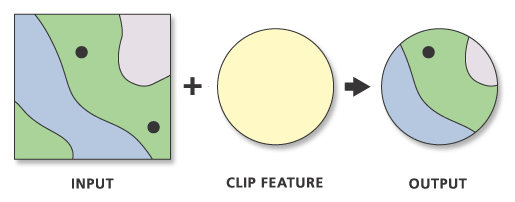


In [117]:
# tidy up the df to numeric
edu_df.Easting = pd.to_numeric(edu_df.Easting, errors="coerce")
edu_df.Northing = pd.to_numeric(edu_df.Northing, errors="coerce")

In [59]:
# locate the null values for easting (no spatial data)
edu_df.loc[edu_df["Easting"].isnull()].head(5)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),EstablishmentStatus (name),ReasonEstablishmentOpened (code),ReasonEstablishmentOpened (name),OpenDate,ReasonEstablishmentClosed (code),ReasonEstablishmentClosed (name),CloseDate,PhaseOfEducation (code),PhaseOfEducation (name),StatutoryLowAge,StatutoryHighAge,Boarders (code),Boarders (name),NurseryProvision (name),OfficialSixthForm (code),OfficialSixthForm (name),Gender (code),Gender (name),ReligiousCharacter (code),ReligiousCharacter (name),ReligiousEthos (name),Diocese (code),Diocese (name),AdmissionsPolicy (code),AdmissionsPolicy (name),SchoolCapacity,SpecialClasses (code),SpecialClasses (name),CensusDate,NumberOfPupils,...,SenUnitOnRoll,SenUnitCapacity,GOR (code),GOR (name),DistrictAdministrative (code),DistrictAdministrative (name),AdministrativeWard (code),AdministrativeWard (name),ParliamentaryConstituency (code),ParliamentaryConstituency (name),UrbanRural (code),UrbanRural (name),GSSLACode (name),Easting,Northing,CensusAreaStatisticWard (name),MSOA (name),LSOA (name),InspectorateName (name),SENStat,SENNoStat,BoardingEstablishment (name),PropsName,PreviousLA (code),PreviousLA (name),PreviousEstablishmentNumber,OfstedRating (name),RSCRegion (name),Country (name),UPRN,SiteName,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),geometry
5040,105046,344,Wirral,2259,Townfield Infant School,01,Community school,4,Local authority maintained schools,2,Closed,00,Not applicable,,00,Not applicable,01-09-1997,2,Primary,5,7,1,No boarders,No Nursery Classes,0,Not applicable,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,,2,No Special Classes,,,...,,,B,North West,9999,,999999,,999,,99,,E08000015,NaN,NaN,,,,,,,,,999,,,,Lancashire and West Yorkshire,,42164491,,0,Not applicable,0,Not applicable,,,999999999,999999999,None
5440,105446,352,Manchester,2221,Princess Junior School,01,Community school,4,Local authority maintained schools,2,Closed,00,Not applicable,,00,Not applicable,10-04-1997,2,Primary,7,11,1,No boarders,No Nursery Classes,0,Not applicable,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,,2,No Special Classes,,,...,,,B,North West,9999,,999999,,999,,99,,E08000003,NaN,NaN,,,,,,,,,999,,,,Lancashire and West Yorkshire,,100012616359,,0,Not applicable,0,Not applicable,,,999999999,999999999,None
15836,115849,850,Hampshire,7078,Lord Wilson School,07,Community special school,5,Special schools,2,Closed,00,Not applicable,,10,Academy Converter,31-03-2014,0,Not applicable,11,16,1,No boarders,Not applicable,0,Not applicable,1,Boys,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,,1,Has Special Classes,,,...,,,J,South East,E07000087,Fareham,E05004523,Park Gate,E14000699,Fareham,C1,(England/Wales) Urban city and town,E10000014,NaN,NaN,,Fareham 001,Fareham 001A,,,,,,917,Pre LGR (1997) Hampshire,,,South-East England and South London,,,,0,Not applicable,0,Not applicable,,,E02004727,E01022758,None
19079,119094,889,Blackburn with Darwen,1032,Audley Nursery School,15,Local authority nursery school,4,Local authority maintained schools,2,Closed,00,Not applicable,,02,Closure,31-08-2009,1,Nursery,3,5,1,No boarders,Has Nursery Classes,0,Not applicable,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,,0,Not applicable,,,...,,,B,North West,E06000008,Blackburn with Darwen,E05011508,Audley & Queen's Park,E14000570,Blackburn,C1,(England/Wales) Urban city and town,E06000008,NaN,NaN,,Blackburn with Darwen 007,Blackburn with Darwen 007A,,,,,,923,Pre LGR (1998) Lancashire,1032,,Lancashire and West Yorkshire,,,,0,Not applicable,0,Not applicable,,,E02002621,E01012571,None
26548,126568,202,Camden,6266,International School of London,11,Other independent school,3,Independent sch

In [28]:
# determine how many rows are in the table
rowcount = edu_df.shape[0]

# determine how many rows have null FIPS
null_fips_rowcount = edu_df.loc[edu_df["Easting"].isnull()].shape[0]

# calculate how much of the data this represents as a percentage
percentage_null_fips = round((null_fips_rowcount / rowcount) * 100, 2)

# use a print statement to report this information
print("There were "+str(null_fips_rowcount)+" records with null Eastings values in the data.\nThis amounts to " +str(percentage_null_fips)+"% of the available data.")

There were 1534 records with null Eastings values in the data.
This amounts to 3.15% of the available data.


In [69]:
# Use the notnull function and the loc function to create a new dataframe without null Easting records
edu_df = edu_df.loc[edu_df['Easting'].notnull()]

In [94]:
# convert to a geopandas spatial df
edu_gpd = gpd.GeoDataFrame(edu_df, geometry = gpd.points_from_xy(edu_df["Easting"], edu_df["Northing"]))
# set the crs & check a row
edu_gpd.set_crs(epsg=27700, inplace=True).head(1)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),EstablishmentStatus (name),ReasonEstablishmentOpened (code),ReasonEstablishmentOpened (name),OpenDate,ReasonEstablishmentClosed (code),ReasonEstablishmentClosed (name),CloseDate,PhaseOfEducation (code),PhaseOfEducation (name),StatutoryLowAge,StatutoryHighAge,Boarders (code),Boarders (name),NurseryProvision (name),OfficialSixthForm (code),OfficialSixthForm (name),Gender (code),Gender (name),ReligiousCharacter (code),ReligiousCharacter (name),ReligiousEthos (name),Diocese (code),Diocese (name),AdmissionsPolicy (code),AdmissionsPolicy (name),SchoolCapacity,SpecialClasses (code),SpecialClasses (name),CensusDate,NumberOfPupils,...,SenUnitOnRoll,SenUnitCapacity,GOR (code),GOR (name),DistrictAdministrative (code),DistrictAdministrative (name),AdministrativeWard (code),AdministrativeWard (name),ParliamentaryConstituency (code),ParliamentaryConstituency (name),UrbanRural (code),UrbanRural (name),GSSLACode (name),Easting,Northing,CensusAreaStatisticWard (name),MSOA (name),LSOA (name),InspectorateName (name),SENStat,SENNoStat,BoardingEstablishment (name),PropsName,PreviousLA (code),PreviousLA (name),PreviousEstablishmentNumber,OfstedRating (name),RSCRegion (name),Country (name),UPRN,SiteName,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),geometry
0,100000,201,City of London,3614,The Aldgate School,02,Voluntary aided school,4,Local authority maintained schools,1,Open,00,Not applicable,,00,Not applicable,,2,Primary,3,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,02,Church of England,Does not apply,CE23,Diocese of London,0,Not applicable,293,2,No Special Classes,16-01-2020,276,...,,,H,London,E09000001,City of London,E05009308,Portsoken,E14000639,Cities of London and Westminster,A1,(England/Wales) Urban major conurbation,E09000001,533498.0,181201.0,,City of London 001,City of London 001F,,,,,,999,,,Outstanding,North-West London and South-Central England,,200000071925,,0,Not applicable,0,Not applicable,,,E02000001,E01032739,POINT (533498.000 181201.000)


In [98]:
#target_area_gpd = gpd.read_file(r"Target_area.shp")
target_area_gpd.to_crs(epsg=27700, inplace=True)

In [99]:
# lets clip the school establishments to the target area
edu_df_clipped = gpd.clip(edu_gpd, target_area_gpd)

In [101]:
# take a look at the data
edu_df_clipped.head(5)

,URN,LA (code),LA (name),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (code),TypeOfEstablishment (name),EstablishmentTypeGroup (code),EstablishmentTypeGroup (name),EstablishmentStatus (code),EstablishmentStatus (name),ReasonEstablishmentOpened (code),ReasonEstablishmentOpened (name),OpenDate,ReasonEstablishmentClosed (code),ReasonEstablishmentClosed (name),CloseDate,PhaseOfEducation (code),PhaseOfEducation (name),StatutoryLowAge,StatutoryHighAge,Boarders (code),Boarders (name),NurseryProvision (name),OfficialSixthForm (code),OfficialSixthForm (name),Gender (code),Gender (name),ReligiousCharacter (code),ReligiousCharacter (name),ReligiousEthos (name),Diocese (code),Diocese (name),AdmissionsPolicy (code),AdmissionsPolicy (name),SchoolCapacity,SpecialClasses (code),SpecialClasses (name),CensusDate,NumberOfPupils,...,SenUnitOnRoll,SenUnitCapacity,GOR (code),GOR (name),DistrictAdministrative (code),DistrictAdministrative (name),AdministrativeWard (code),AdministrativeWard (name),ParliamentaryConstituency (code),ParliamentaryConstituency (name),UrbanRural (code),UrbanRural (name),GSSLACode (name),Easting,Northing,CensusAreaStatisticWard (name),MSOA (name),LSOA (name),InspectorateName (name),SENStat,SENNoStat,BoardingEstablishment (name),PropsName,PreviousLA (code),PreviousLA (name),PreviousEstablishmentNumber,OfstedRating (name),RSCRegion (name),Country (name),UPRN,SiteName,QABName (code),QABName (name),EstablishmentAccredited (code),EstablishmentAccredited (name),QABReport,CHNumber,MSOA (code),LSOA (code),geometry
5296,105302,351,Bury,2033,Higher Lane Primary School,01,Community school,4,Local authority maintained schools,2,Closed,00,Not applicable,,10,Academy Converter,30-06-2017,2,Primary,4,11,1,No boarders,No Nursery Classes,2,Does not have a sixth form,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,420,2,No Special Classes,19-01-2017,465,...,,,B,North West,E08000002,Bury,E05000677,Pilkington Park,E14000612,Bury South,A1,(England/Wales) Urban major conurbation,E08000002,380544.0,405480.0,,Bury 020,Bury 020B,,,,,,999,,,Good,Lancashire and West Yorkshire,,10003110403,,0,Not applicable,0,Not applicable,,,E02001038,E01004986,POINT (380544.000 405480.000)
5300,105306,351,Bury,2037,Heaton Park Primary School,01,Community school,4,Local authority maintained schools,1,Open,00,Not applicable,,00,Not applicable,,2,Primary,2,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,438,2,No Special Classes,16-01-2020,418,...,,,B,North West,E08000002,Bury,E05000674,Holyrood,E14000612,Bury South,A1,(England/Wales) Urban major conurbation,E08000002,381614.0,404800.0,,Bury 022,Bury 022C,,,,,,999,,,Good,Lancashire and West Yorkshire,,100012713245,,0,Not applicable,0,Not applicable,,,E02001040,E01004971,POINT (381614.000 404800.000)
5301,105307,351,Bury,2038,Park View Primary School,01,Community school,4,Local authority maintained schools,1,Open,00,Not applicable,,00,Not applicable,,2,Primary,3,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,403,2,No Special Classes,16-01-2020,446,...,,,B,North West,E08000002,Bury,E05000684,Sedgley,E14000612,Bury South,A1,(England/Wales) Urban major conurbation,E08000002,381771.0,403342.0,,Bury 023,Bury 023E,,,,,,999,,,Good,Lancashire and West Yorkshire,,100012689164,,0,Not applicable,0,Not applicable,,,E02001041,E01005045,POINT (381771.000 403342.000)
5302,105308,351,Bury,2039,Sedgley Park Community Primary School,01,Community school,4,Local authority maintained schools,1,Open,00,Not applicable,,00,Not applicable,,2,Primary,3,11,1,No boarders,Has Nursery Classes,2,Does not have a sixth form,3,Mixed,00,Does not apply,Does not apply,0000,Not applicable,0,Not applicable,330,2,No Special Classes,16-01-2020,318,...,,,B,North West,E08000002,Bury,E05000684,Sedgley,E14000612,Bury South,A1,(England

In [108]:
# determine how many rows are in the table
rowcount_clipped = edu_df_clipped.shape[0]

# calculate how much of the data this represents as a percentage
percentage_clipped = round((rowcount_clipped / rowcount) * 100, 2)

# how many school establishments and what % of the total school establishments are in our target area
print("There were "+str(rowcount_clipped)+" records of school establishments in the target area.\nThis amounts to " +str(percentage_clipped)+"% of the available data.")

There were 2098 records of school establishments in the target area.
This amounts to 4.3% of the available data.


#### (6) Plot the engagement 30 min travel time area and school establishments within the area

1. Publish the shp ***pdnpa/arcgis.com/content***
2. Display on a map widget

In [111]:
# lets save as a feature collection to map the data
edu_df_clipped.to_file(r"School_Establishments.shp")

In [114]:
# define the properties
School_Establishments_properties = {"title": "School Establishments",
                          "description": "school establishments in 30 mins drive time from education centres",
                          "tags": "polygon, engagement",
                          "type": "Shapefile"}

In [115]:
# add & publish to pdnpa/arcgis
School_Establishments = mygis.content.add(School_Establishments_properties, data = r"School_Establishments.zip")
School_Establishments = School_Establishments.publish()

<Item title:"School Establishments" type:Feature Layer Collection owner:david.alexander_PDNPA>
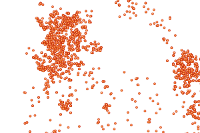

In [116]:
# show the published data
School_Establishments = mygis.content.get("450f360a86f345d380e08ef1d901cb90")
display(School_Establishments)

In [118]:
# finally lets map the data 
Engagement_schools_map.add_layer(School_Establishments)
Engagement_schools_map

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

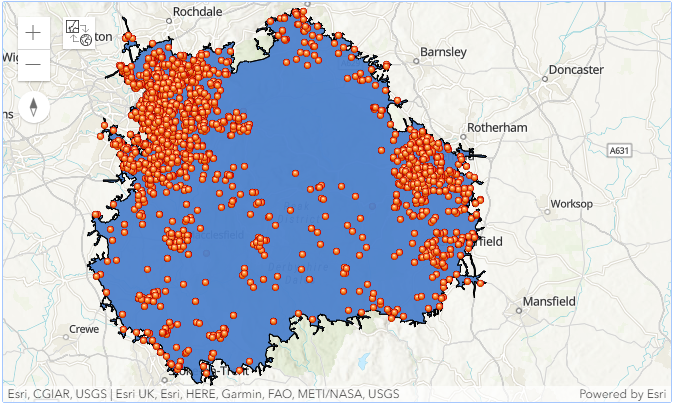

## Analysis of school establishments

### Analysis Steps

1. Subset data based on type of school Establishment
2. Analyse and rank by variables described in methodology

Work to be completed by December 2020